# Feasibility Study & Recommendations for Opening a Restaurant in Pune
## IBM Applied Data Science Capstone Project
### The Battle of Neighborhoods


Import the required modules

In [22]:
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import numpy as np
import pandas as pd
import folium
import requests
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Get coordinates of all pincodes (zip code) of Pune city

In [23]:
pin_lat_long = []
for pin in range(411001,411062):
    print('Fetching geo coordinates for {}'.format(pin))
    address = str(pin) + ', Pune, India'
    geolocator = Nominatim(user_agent="pune_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    pin_lat_long.append([pin, latitude, longitude])
pin_lat_long

Fetching geo coordinates for 411001
Fetching geo coordinates for 411002
Fetching geo coordinates for 411003
Fetching geo coordinates for 411004
Fetching geo coordinates for 411005
Fetching geo coordinates for 411006
Fetching geo coordinates for 411007
Fetching geo coordinates for 411008
Fetching geo coordinates for 411009
Fetching geo coordinates for 411010
Fetching geo coordinates for 411011
Fetching geo coordinates for 411012
Fetching geo coordinates for 411013
Fetching geo coordinates for 411014
Fetching geo coordinates for 411015
Fetching geo coordinates for 411016
Fetching geo coordinates for 411017
Fetching geo coordinates for 411018
Fetching geo coordinates for 411019
Fetching geo coordinates for 411020
Fetching geo coordinates for 411021
Fetching geo coordinates for 411022
Fetching geo coordinates for 411023
Fetching geo coordinates for 411024
Fetching geo coordinates for 411025
Fetching geo coordinates for 411026
Fetching geo coordinates for 411027
Fetching geo coordinates for

[[411001, 18.5298629, 73.8760869],
 [411002, 18.5095844, 73.8585026],
 [411003, 18.5710074, 73.8383273],
 [411004, 18.5087265, 73.83086905279255],
 [411005, 18.4580909700108, 73.9293125124155],
 [411006, 18.5721375, 73.8788439],
 [411007, 18.521428, 73.8544541],
 [411008, 18.542318334707847, 73.80930474604361],
 [411009, 18.4853019, 73.8511287],
 [411010, 18.1157975, 75.0269762],
 [411011, 18.59592547652776, 73.93761890238277],
 [411012, 18.585276666666665, 73.83030593333334],
 [411013, 18.511166, 73.928155],
 [411014, 18.5627909, 73.91371135],
 [411015, 18.579194888898932, 73.88636319619278],
 [411016, 18.5291854, 73.8334444],
 [411017, 18.5741788, 73.7731743],
 [411018, 18.6332662, 73.81618749769493],
 [411019, 18.6582, 73.8046793],
 [411020, 18.55593608255426, 73.83683021403759],
 [411021, 18.55298685, 73.75500526891248],
 [411022, 18.521428, 73.8544541],
 [411023, 18.8250074, 74.3745183],
 [411024, 18.4402041, 73.7753538],
 [411025, 18.3993407, 73.7333619],
 [411026, 18.6349668, 73

Convert the geospatial coordinated for center of each pincode of Pune city into a dataframe

In [24]:
pune_pincodes = pd.DataFrame(pin_lat_long, columns=['pincode', 'lat', 'lng'])
pune_pincodes.head()

,pincode,lat,lng
0,411001,18.529863,73.876087
1,411002,18.509584,73.858503
2,411003,18.571007,73.838327
3,411004,18.508727,73.830869
4,411005,18.458091,73.929313


Visualize Pune pincodes on map

In [25]:
address = 'Pune, India'
geolocator = Nominatim(user_agent="pune_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_pune = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for ind in pune_pincodes.index:
    pin = pune_pincodes['pincode'][ind]
    lat = pune_pincodes['lat'][ind]
    lng = pune_pincodes['lng'][ind]
    label = '{}'.format(pin)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_pune)
    
map_pune

Set credentials for Foursquare to fetch data using Foursquare API

In [26]:
CLIENT_ID = 'E1FHC5NSP5KEE14G2CB0420DOCZEB3LMM2BYT0HCZWEJOUGU' # your Foursquare ID
CLIENT_SECRET = 'L2TXKCQNW5JPBSYYP0SH3BR4EHFPRASFHJQLNQ5PC5FEWXJD' # your Foursquare Secret
VERSION = '20200101' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: E1FHC5NSP5KEE14G2CB0420DOCZEB3LMM2BYT0HCZWEJOUGU
CLIENT_SECRET:L2TXKCQNW5JPBSYYP0SH3BR4EHFPRASFHJQLNQ5PC5FEWXJD


Part 1: Fetch venues/restaurants data using Foursquare API
<br>A) Construct URL's with geospatial cooridnates of each pincode and fetch upto 100 data points/venues from each pincode within the city
<br>B) Use requests to use API and fetch data
<br>C) Parse json and prune required features
<br>D) Convert the required data into data frame
<br>E) Convert dataframe into CSV and save the file

In [6]:
# Construct URLs. One URL for each pincode
LIMIT = 1000 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
fqs_urls = []
for ind in pune_pincodes.index:
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        pune_pincodes['lat'][ind], 
        pune_pincodes['lng'][ind], 
        radius, 
        LIMIT)
    fqs_urls.append(url)
    
fqs_urls[0:5]

['https://api.foursquare.com/v2/venues/explore?&client_id=E1FHC5NSP5KEE14G2CB0420DOCZEB3LMM2BYT0HCZWEJOUGU&client_secret=L2TXKCQNW5JPBSYYP0SH3BR4EHFPRASFHJQLNQ5PC5FEWXJD&v=20200101&ll=18.5298629,73.8760869&radius=2000&limit=1000',
 'https://api.foursquare.com/v2/venues/explore?&client_id=E1FHC5NSP5KEE14G2CB0420DOCZEB3LMM2BYT0HCZWEJOUGU&client_secret=L2TXKCQNW5JPBSYYP0SH3BR4EHFPRASFHJQLNQ5PC5FEWXJD&v=20200101&ll=18.5095844,73.8585026&radius=2000&limit=1000',
 'https://api.foursquare.com/v2/venues/explore?&client_id=E1FHC5NSP5KEE14G2CB0420DOCZEB3LMM2BYT0HCZWEJOUGU&client_secret=L2TXKCQNW5JPBSYYP0SH3BR4EHFPRASFHJQLNQ5PC5FEWXJD&v=20200101&ll=18.5710074,73.8383273&radius=2000&limit=1000',
 'https://api.foursquare.com/v2/venues/explore?&client_id=E1FHC5NSP5KEE14G2CB0420DOCZEB3LMM2BYT0HCZWEJOUGU&client_secret=L2TXKCQNW5JPBSYYP0SH3BR4EHFPRASFHJQLNQ5PC5FEWXJD&v=20200101&ll=18.5087265,73.83086905279255&radius=2000&limit=1000',
 'https://api.foursquare.com/v2/venues/explore?&client_id=E1FHC5NSP5K

In [8]:
# Actualy fetch data using Foursqauare API
success = 0
fqs_results_jsons = []

for ind,url in enumerate(fqs_urls):
    result = requests.get(url).json()
    if result['meta']['code'] == 200:
        success += 1
    print("Fetching ... {} ... success {}/{}".format(ind+1, success, ind+1))
    fqs_results_jsons.append(result)

Fetching ... 1 ... success 1/1
Fetching ... 2 ... success 2/2
Fetching ... 3 ... success 3/3
Fetching ... 4 ... success 4/4
Fetching ... 5 ... success 5/5
Fetching ... 6 ... success 6/6
Fetching ... 7 ... success 7/7
Fetching ... 8 ... success 8/8
Fetching ... 9 ... success 9/9
Fetching ... 10 ... success 10/10
Fetching ... 11 ... success 11/11
Fetching ... 12 ... success 12/12
Fetching ... 13 ... success 13/13
Fetching ... 14 ... success 14/14
Fetching ... 15 ... success 15/15
Fetching ... 16 ... success 16/16
Fetching ... 17 ... success 17/17
Fetching ... 18 ... success 18/18
Fetching ... 19 ... success 19/19
Fetching ... 20 ... success 20/20
Fetching ... 21 ... success 21/21
Fetching ... 22 ... success 22/22
Fetching ... 23 ... success 23/23
Fetching ... 24 ... success 24/24
Fetching ... 25 ... success 25/25
Fetching ... 26 ... success 26/26
Fetching ... 27 ... success 27/27
Fetching ... 28 ... success 28/28
Fetching ... 29 ... success 29/29
Fetching ... 30 ... success 30/30
Fetchin

In [66]:
# Convert fetched data from json to dataframe consisting of chosen features

pune_venues = []
for ind,jsons in enumerate(fqs_results_jsons):
    print('Processing .... {}'.format(ind))
    for res in range(min(jsons['response']['totalResults'],100)):
        venue = []
        venue.append(jsons['response']['groups'][0]['items'][res]['venue']['name'])
        venue.append(jsons['response']['groups'][0]['items'][res]['venue']['location']['lat'])
        venue.append(jsons['response']['groups'][0]['items'][res]['venue']['location']['lng'])
        try:
            venue.append(jsons['response']['groups'][0]['items'][res]['venue']['location']['postalCode'])
        except:
            venue.append(pune_pincodes['pincode'][ind])
        venue.append(jsons['response']['groups'][0]['items'][res]['venue']['categories'][0]['shortName'])
        pune_venues.append(venue)

Processing .... 0
Processing .... 1
Processing .... 2
Processing .... 3
Processing .... 4
Processing .... 5
Processing .... 6
Processing .... 7
Processing .... 8
Processing .... 9
Processing .... 10
Processing .... 11
Processing .... 12
Processing .... 13
Processing .... 14
Processing .... 15
Processing .... 16
Processing .... 17
Processing .... 18
Processing .... 19
Processing .... 20
Processing .... 21
Processing .... 22
Processing .... 23
Processing .... 24
Processing .... 25
Processing .... 26
Processing .... 27
Processing .... 28
Processing .... 29
Processing .... 30
Processing .... 31
Processing .... 32
Processing .... 33
Processing .... 34
Processing .... 35
Processing .... 36
Processing .... 37
Processing .... 38
Processing .... 39
Processing .... 40
Processing .... 41
Processing .... 42
Processing .... 43
Processing .... 44
Processing .... 45
Processing .... 46
Processing .... 47
Processing .... 48
Processing .... 49
Processing .... 50
Processing .... 51
Processing .... 52
Pro

Convert Foursquare venues into dataframe and save it to disk in CSV format 

In [67]:
fqs_venues = pd.DataFrame(pune_venues, columns=['name', 'lat', 'lng', 'pincode', 'type'])

In [68]:
fqs_venues.to_csv('foursquare.csv', index=False)

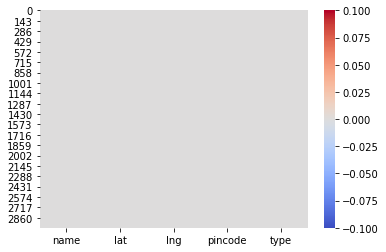

In [69]:
import seaborn as sns
sns.heatmap(fqs_venues.isnull(), cmap='coolwarm')

In [65]:
#for ind in fqs_venues.index:
#if fqs_venues['pincode'].isnull() == True:
#        fqs_venues['pincode'][ind]

0       False
1       False
2       False
3        True
4       False
        ...  
2994    False
2995     True
2996     True
2997     True
2998    False
Name: pincode, Length: 2999, dtype: bool

## Section 2: Get data from Zomato

1. Set API credential key for Zomato
2. Prepare search query based on coordinates of restaurants found in FourSquare API
3. Fetch data using requests and Zomato API
4. Convert the response JSON into dataframe
5. As zomato has limit of 1000 API calls, call multiple times (either on different days or using seperate credentials)
6. Save it to disk in CSV format so it can be fetched whenever needed for further analysis

In [13]:
# Prepare URLs
zomato_urls = []

for ind in fqs_venues.index:
    name = fqs_venues['name'][ind]
    lat = fqs_venues['lat'][ind]
    lng = fqs_venues['lng'][ind]
    url = ('https://developers.zomato.com/api/v2.1/search?q{}' + '&start=0&count=20&lat={}&lon={}&sort=real_distance').format(name,lat,lng)
    zomato_urls.append(url)

Use zomato developer API to fetch restaurant data

In [15]:
zomato_results = []

headers = {'user-key': 'e2ef4f947cde32306783626bff7c4817'}
count = 0
for url in zomato_urls[0:999]:
    result = requests.get(url, headers = headers).json()
    zomato_results.append(result)
    print('Finished processing ... {}'.format(count))
    count += 1

headers = {'user-key': '7fd1f06ce6563edc630620a7b37ea406'}
count = 0
for url in zomato_urls[1000:1999]:
    result = requests.get(url, headers = headers).json()
    zomato_results.append(result)
    print('Finished processing ... {}'.format(count))
    count += 1

headers = {'user-key': 'a04982a1d6e7d52e614479972e27cd9c'}
count = 0
for url in zomato_urls[2000:2999]:
    result = requests.get(url, headers = headers).json()
    zomato_results.append(result)
    print('Finished processing ... {}'.format(count))
    count += 1

Finished processing ... 0
Finished processing ... 1
Finished processing ... 2
Finished processing ... 3
Finished processing ... 4
Finished processing ... 5
Finished processing ... 6
Finished processing ... 7
Finished processing ... 8
Finished processing ... 9
Finished processing ... 10
Finished processing ... 11
Finished processing ... 12
Finished processing ... 13
Finished processing ... 14
Finished processing ... 15
Finished processing ... 16
Finished processing ... 17
Finished processing ... 18
Finished processing ... 19
Finished processing ... 20
Finished processing ... 21
Finished processing ... 22
Finished processing ... 23
Finished processing ... 24
Finished processing ... 25
Finished processing ... 26
Finished processing ... 27
Finished processing ... 28
Finished processing ... 29
Finished processing ... 30
Finished processing ... 31
Finished processing ... 32
Finished processing ... 33
Finished processing ... 34
Finished processing ... 35
Finished processing ... 36
Finished pr

Finished processing ... 297
Finished processing ... 298
Finished processing ... 299
Finished processing ... 300
Finished processing ... 301
Finished processing ... 302
Finished processing ... 303
Finished processing ... 304
Finished processing ... 305
Finished processing ... 306
Finished processing ... 307
Finished processing ... 308
Finished processing ... 309
Finished processing ... 310
Finished processing ... 311
Finished processing ... 312
Finished processing ... 313
Finished processing ... 314
Finished processing ... 315
Finished processing ... 316
Finished processing ... 317
Finished processing ... 318
Finished processing ... 319
Finished processing ... 320
Finished processing ... 321
Finished processing ... 322
Finished processing ... 323
Finished processing ... 324
Finished processing ... 325
Finished processing ... 326
Finished processing ... 327
Finished processing ... 328
Finished processing ... 329
Finished processing ... 330
Finished processing ... 331
Finished processing 

Finished processing ... 590
Finished processing ... 591
Finished processing ... 592
Finished processing ... 593
Finished processing ... 594
Finished processing ... 595
Finished processing ... 596
Finished processing ... 597
Finished processing ... 598
Finished processing ... 599
Finished processing ... 600
Finished processing ... 601
Finished processing ... 602
Finished processing ... 603
Finished processing ... 604
Finished processing ... 605
Finished processing ... 606
Finished processing ... 607
Finished processing ... 608
Finished processing ... 609
Finished processing ... 610
Finished processing ... 611
Finished processing ... 612
Finished processing ... 613
Finished processing ... 614
Finished processing ... 615
Finished processing ... 616
Finished processing ... 617
Finished processing ... 618
Finished processing ... 619
Finished processing ... 620
Finished processing ... 621
Finished processing ... 622
Finished processing ... 623
Finished processing ... 624
Finished processing 

Finished processing ... 883
Finished processing ... 884
Finished processing ... 885
Finished processing ... 886
Finished processing ... 887
Finished processing ... 888
Finished processing ... 889
Finished processing ... 890
Finished processing ... 891
Finished processing ... 892
Finished processing ... 893
Finished processing ... 894
Finished processing ... 895
Finished processing ... 896
Finished processing ... 897
Finished processing ... 898
Finished processing ... 899
Finished processing ... 900
Finished processing ... 901
Finished processing ... 902
Finished processing ... 903
Finished processing ... 904
Finished processing ... 905
Finished processing ... 906
Finished processing ... 907
Finished processing ... 908
Finished processing ... 909
Finished processing ... 910
Finished processing ... 911
Finished processing ... 912
Finished processing ... 913
Finished processing ... 914
Finished processing ... 915
Finished processing ... 916
Finished processing ... 917
Finished processing 

Finished processing ... 181
Finished processing ... 182
Finished processing ... 183
Finished processing ... 184
Finished processing ... 185
Finished processing ... 186
Finished processing ... 187
Finished processing ... 188
Finished processing ... 189
Finished processing ... 190
Finished processing ... 191
Finished processing ... 192
Finished processing ... 193
Finished processing ... 194
Finished processing ... 195
Finished processing ... 196
Finished processing ... 197
Finished processing ... 198
Finished processing ... 199
Finished processing ... 200
Finished processing ... 201
Finished processing ... 202
Finished processing ... 203
Finished processing ... 204
Finished processing ... 205
Finished processing ... 206
Finished processing ... 207
Finished processing ... 208
Finished processing ... 209
Finished processing ... 210
Finished processing ... 211
Finished processing ... 212
Finished processing ... 213
Finished processing ... 214
Finished processing ... 215
Finished processing 

Finished processing ... 475
Finished processing ... 476
Finished processing ... 477
Finished processing ... 478
Finished processing ... 479
Finished processing ... 480
Finished processing ... 481
Finished processing ... 482
Finished processing ... 483
Finished processing ... 484
Finished processing ... 485
Finished processing ... 486
Finished processing ... 487
Finished processing ... 488
Finished processing ... 489
Finished processing ... 490
Finished processing ... 491
Finished processing ... 492
Finished processing ... 493
Finished processing ... 494
Finished processing ... 495
Finished processing ... 496
Finished processing ... 497
Finished processing ... 498
Finished processing ... 499
Finished processing ... 500
Finished processing ... 501
Finished processing ... 502
Finished processing ... 503
Finished processing ... 504
Finished processing ... 505
Finished processing ... 506
Finished processing ... 507
Finished processing ... 508
Finished processing ... 509
Finished processing 

Finished processing ... 768
Finished processing ... 769
Finished processing ... 770
Finished processing ... 771
Finished processing ... 772
Finished processing ... 773
Finished processing ... 774
Finished processing ... 775
Finished processing ... 776
Finished processing ... 777
Finished processing ... 778
Finished processing ... 779
Finished processing ... 780
Finished processing ... 781
Finished processing ... 782
Finished processing ... 783
Finished processing ... 784
Finished processing ... 785
Finished processing ... 786
Finished processing ... 787
Finished processing ... 788
Finished processing ... 789
Finished processing ... 790
Finished processing ... 791
Finished processing ... 792
Finished processing ... 793
Finished processing ... 794
Finished processing ... 795
Finished processing ... 796
Finished processing ... 797
Finished processing ... 798
Finished processing ... 799
Finished processing ... 800
Finished processing ... 801
Finished processing ... 802
Finished processing 

Finished processing ... 65
Finished processing ... 66
Finished processing ... 67
Finished processing ... 68
Finished processing ... 69
Finished processing ... 70
Finished processing ... 71
Finished processing ... 72
Finished processing ... 73
Finished processing ... 74
Finished processing ... 75
Finished processing ... 76
Finished processing ... 77
Finished processing ... 78
Finished processing ... 79
Finished processing ... 80
Finished processing ... 81
Finished processing ... 82
Finished processing ... 83
Finished processing ... 84
Finished processing ... 85
Finished processing ... 86
Finished processing ... 87
Finished processing ... 88
Finished processing ... 89
Finished processing ... 90
Finished processing ... 91
Finished processing ... 92
Finished processing ... 93
Finished processing ... 94
Finished processing ... 95
Finished processing ... 96
Finished processing ... 97
Finished processing ... 98
Finished processing ... 99
Finished processing ... 100
Finished processing ... 101

Finished processing ... 359
Finished processing ... 360
Finished processing ... 361
Finished processing ... 362
Finished processing ... 363
Finished processing ... 364
Finished processing ... 365
Finished processing ... 366
Finished processing ... 367
Finished processing ... 368
Finished processing ... 369
Finished processing ... 370
Finished processing ... 371
Finished processing ... 372
Finished processing ... 373
Finished processing ... 374
Finished processing ... 375
Finished processing ... 376
Finished processing ... 377
Finished processing ... 378
Finished processing ... 379
Finished processing ... 380
Finished processing ... 381
Finished processing ... 382
Finished processing ... 383
Finished processing ... 384
Finished processing ... 385
Finished processing ... 386
Finished processing ... 387
Finished processing ... 388
Finished processing ... 389
Finished processing ... 390
Finished processing ... 391
Finished processing ... 392
Finished processing ... 393
Finished processing 

Finished processing ... 652
Finished processing ... 653
Finished processing ... 654
Finished processing ... 655
Finished processing ... 656
Finished processing ... 657
Finished processing ... 658
Finished processing ... 659
Finished processing ... 660
Finished processing ... 661
Finished processing ... 662
Finished processing ... 663
Finished processing ... 664
Finished processing ... 665
Finished processing ... 666
Finished processing ... 667
Finished processing ... 668
Finished processing ... 669
Finished processing ... 670
Finished processing ... 671
Finished processing ... 672
Finished processing ... 673
Finished processing ... 674
Finished processing ... 675
Finished processing ... 676
Finished processing ... 677
Finished processing ... 678
Finished processing ... 679
Finished processing ... 680
Finished processing ... 681
Finished processing ... 682
Finished processing ... 683
Finished processing ... 684
Finished processing ... 685
Finished processing ... 686
Finished processing 

Finished processing ... 945
Finished processing ... 946
Finished processing ... 947
Finished processing ... 948
Finished processing ... 949
Finished processing ... 950
Finished processing ... 951
Finished processing ... 952
Finished processing ... 953
Finished processing ... 954
Finished processing ... 955
Finished processing ... 956
Finished processing ... 957
Finished processing ... 958
Finished processing ... 959
Finished processing ... 960
Finished processing ... 961
Finished processing ... 962
Finished processing ... 963
Finished processing ... 964
Finished processing ... 965
Finished processing ... 966
Finished processing ... 967
Finished processing ... 968
Finished processing ... 969
Finished processing ... 970
Finished processing ... 971
Finished processing ... 972
Finished processing ... 973
Finished processing ... 974
Finished processing ... 975
Finished processing ... 976
Finished processing ... 977
Finished processing ... 978
Finished processing ... 979
Finished processing 

Extract required data fields from the resultant JSON

In [18]:
zomato_restaurants = []
for rest in zomato_results:
    for r in range(0,20):
        venue = []
        try:
            venue.append(rest['restaurants'][r]['restaurant']['name'])
        except:
            continue
        venue.append(rest['restaurants'][r]['restaurant']['location']['latitude'])
        venue.append(rest['restaurants'][r]['restaurant']['location']['longitude'])
        venue.append(rest['restaurants'][r]['restaurant']['average_cost_for_two'])
        venue.append(rest['restaurants'][r]['restaurant']['price_range'])
        venue.append(rest['restaurants'][r]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(rest['restaurants'][r]['restaurant']['user_rating']['votes'])
        venue.append(rest['restaurants'][r]['restaurant']['cuisines'])
        venue.append(rest['restaurants'][r]['restaurant']['highlights'])
        venue.append(rest['restaurants'][r]['restaurant']['all_reviews_count'])
        venue.append(rest['restaurants'][r]['restaurant']['photo_count'])
        venue.append(rest['restaurants'][0]['restaurant']['has_table_booking'])
        venue.append(rest['restaurants'][0]['restaurant']['has_online_delivery'])
        zomato_restaurants.append(venue)

Convert it into dataframe, remove duplicates and store it in CSV format

In [19]:
zomato = pd.DataFrame(zomato_restaurants, columns = ['name', 'latitude', 'longitude', 'average_cost_for_two', 'price_range', 'aggregate_rating', 'votes', 'cuisines', 'highlights', 'all_reviews_count', 'photo_count', 'has_table_booking', 'has_online_delivery'])
zomato.drop_duplicates(subset ="name", keep = 'first', inplace=True)
zomato.to_csv('zomato.csv', index=False)

In [21]:
zomato.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3684 entries, 0 to 47239
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   name                  3684 non-null   object
 1   latitude              3684 non-null   object
 2   longitude             3684 non-null   object
 3   average_cost_for_two  3684 non-null   int64 
 4   price_range           3684 non-null   int64 
 5   aggregate_rating      3684 non-null   object
 6   votes                 3684 non-null   int64 
 7   cuisines              3684 non-null   object
 8   highlights            3684 non-null   object
 9   all_reviews_count     3684 non-null   int64 
 10  photo_count           3684 non-null   int64 
 11  has_table_booking     3684 non-null   int64 
 12  has_online_delivery   3684 non-null   int64 
dtypes: int64(7), object(6)
memory usage: 402.9+ KB
